# Which genre of video games had more global unit sales as of 2016: action or sports games?

Dataset: https://www.kaggle.com/gregorut/videogamesales

This dataset only contains video games that sold over 100,000 copies as of 2016 (according to the author). However, the author likely made a typo, and the dataset only contains video games that sold over *10,000* copies. The global sales are in millions, and the lowest global sales are 0.01 million, which is 10,000.

According to the author, the data was scraped from VGChartz, a website which charts video games. The data includes all cumulative (so from before 2016, too) global unit sales (in millions). The data was collected in late 2016; the data was uploaded to Kaggle on 10/26/2016, so it may have been collected a few days prior.

# Preparing the Data for Analysis

In [1]:
# necessary imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# load csv
df = pd.read_csv('vgsales.csv')

# print first 5 rows of dataset
print(df.head())

   Rank                      Name Platform    Year         Genre Publisher  \
0     1                Wii Sports      Wii  2006.0        Sports  Nintendo   
1     2         Super Mario Bros.      NES  1985.0      Platform  Nintendo   
2     3            Mario Kart Wii      Wii  2008.0        Racing  Nintendo   
3     4         Wii Sports Resort      Wii  2009.0        Sports  Nintendo   
4     5  Pokemon Red/Pokemon Blue       GB  1996.0  Role-Playing  Nintendo   

   NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  
0     41.49     29.02      3.77         8.46         82.74  
1     29.08      3.58      6.81         0.77         40.24  
2     15.85     12.88      3.79         3.31         35.82  
3     15.75     11.01      3.28         2.96         33.00  
4     11.27      8.89     10.22         1.00         31.37  


In [2]:
# find which columns contain null values
print(df.columns[df.isna().any()])

# There are null values in the 'Year' and 'Publisher' columns, both of which aren't needed for this statistical analysis.

Index(['Year', 'Publisher'], dtype='object')


In [3]:
# get only the 2 columns needed for this analysis - genre and global sales
df_genres = df[['Genre', 'Global_Sales']]

# select only rows with 'Sports' or 'Action' genre since these are the genres of interest
df_genres = df_genres[(df_genres['Genre'] == 'Sports') | (df_genres['Genre'] == 'Action')]

# split into dataframes with only sports and only action genre
df_sports = df_genres[df_genres['Genre'] == 'Sports']
df_action = df_genres[df_genres['Genre'] == 'Action']

# verify that the new dataframes contain only one genre
print(df_sports)
print(df_action)

# Note: this also shows there are 2346 sports games in the dataset and 3316 action games.
# The lowest global sales are 0.01 million for both populations.

        Genre  Global_Sales
0      Sports         82.74
3      Sports         33.00
13     Sports         22.72
14     Sports         22.00
77     Sports          8.49
...       ...           ...
16576  Sports          0.01
16578  Sports          0.01
16579  Sports          0.01
16581  Sports          0.01
16587  Sports          0.01

[2346 rows x 2 columns]
        Genre  Global_Sales
16     Action         21.40
17     Action         20.81
23     Action         16.38
24     Action         16.15
38     Action         13.10
...       ...           ...
16564  Action          0.01
16567  Action          0.01
16582  Action          0.01
16583  Action          0.01
16589  Action          0.01

[3316 rows x 2 columns]


In [4]:
# convert both dataframes to numpy arrays for easier data handling/sampling in the future
sports = df_sports['Global_Sales'].values
action = df_action['Global_Sales'].values

print(sports)
print(action)

[8.274e+01 3.300e+01 2.272e+01 ... 1.000e-02 1.000e-02 1.000e-02]
[2.140e+01 2.081e+01 1.638e+01 ... 1.000e-02 1.000e-02 1.000e-02]


# Data Visualization & Summary Statistics

In [5]:
# Sports Genre summary statistics
df_sports.describe()

,Global_Sales
count,2346.000000
mean,0.567319
std,2.089716
min,0.010000
25%,0.090000
50%,0.220000
75%,0.560000
max,82.740000


In [6]:
# Action Genre summary statistics
df_action.describe()

,Global_Sales
count,3316.000000
mean,0.528100
std,1.156427
min,0.010000
25%,0.070000
50%,0.190000
75%,0.500000
max,21.400000


### Outliers

Outliers are calculated using the following formulas:

$$ lower\ outlier\ <\ Q_{1}\ -\ \left(1.5\cdot IQR\right) $$
$$ upper\ outlier\ >\ Q_{3}\ +\ \left(1.5\cdot IQR\right) $$

The code for this is in the cell below this one.

In [7]:
# class to calculate outliers
class OutlierCalculatorClass:
    # initialize with given dataframe
    def __init__(self, df_to_use):
        self.df_to_use = df_to_use
        
    # calculate IQR
    # IQR = Q3 - Q1
    def iqr_calculation(self):
        self.q3 = self.df_to_use['Global_Sales'].quantile(.75)
        self.q1 = self.df_to_use['Global_Sales'].quantile(.25)
        self.IQR = self.q3 - self.q1
        
        print("IQR: {IQR: .3f}".format(IQR=self.IQR))
    
    # Find outlier cutoffs
    # For the lower outlier cutoff: Q1 - (1.5 * IQR). Any values below this are outliers.
    # For the upper outlier cutoff: Q3 + (1.5 * IQR). Any values above this are outliers.
    def outlier_cutoffs(self):
        self.lower_outlier_cutoff = self.q1 - (1.5 * self.IQR)
        self.upper_outlier_cutoff = self.q3 + (1.5 * self.IQR)
        
        print("Lower Outlier Cutoff: {low_cutoff: .3f}".format(low_cutoff=self.lower_outlier_cutoff))
        print("Upper Outlier Cutoff: {high_cutoff: .3f}".format(high_cutoff=self.upper_outlier_cutoff))
        """return (self.lower_outlier_cutoff, self.upper_outlier_cutoff)"""
    
    # check how many data values are under the lower outlier cutoff and how many are above the upper outlier cutoff
    def num_outliers(self):
        self.lower_outlier_count = len(self.df_to_use[self.df_to_use['Global_Sales'] < self.lower_outlier_cutoff])
        self.upper_outlier_count = len(self.df_to_use[self.df_to_use['Global_Sales'] > self.upper_outlier_cutoff])
        self.total_outlier_count = self.upper_outlier_count + self.lower_outlier_count
        
        print("There are {lower} lower outliers and {upper} upper outliers."
          .format(lower=self.lower_outlier_count, upper=self.upper_outlier_count))
        print("There are {total_outliers} total outliers."
          .format(total_outliers=self.total_outlier_count))

In [8]:
# Sports Genre Outliers:

# initialize class instance for sports genre outliers
outliers = OutlierCalculatorClass(df_sports)

# get IQR
outliers.iqr_calculation()

# find outlier cutoffs
outliers.outlier_cutoffs()

# How many total outliers are there?
outliers.num_outliers()

IQR:  0.470
Lower Outlier Cutoff: -0.615
Upper Outlier Cutoff:  1.265
There are 0 lower outliers and 226 upper outliers.
There are 226 total outliers.


In [9]:
# Action Genre Outliers

# initialize class instance for action genre outliers
outliers = OutlierCalculatorClass(df_action)

# get IQR
outliers.iqr_calculation()

# find outlier cutoffs
outliers.outlier_cutoffs()

# How many total outliers are there?
outliers.num_outliers()

IQR:  0.430
Lower Outlier Cutoff: -0.575
Upper Outlier Cutoff:  1.145
There are 0 lower outliers and 358 upper outliers.
There are 358 total outliers.


### Histograms

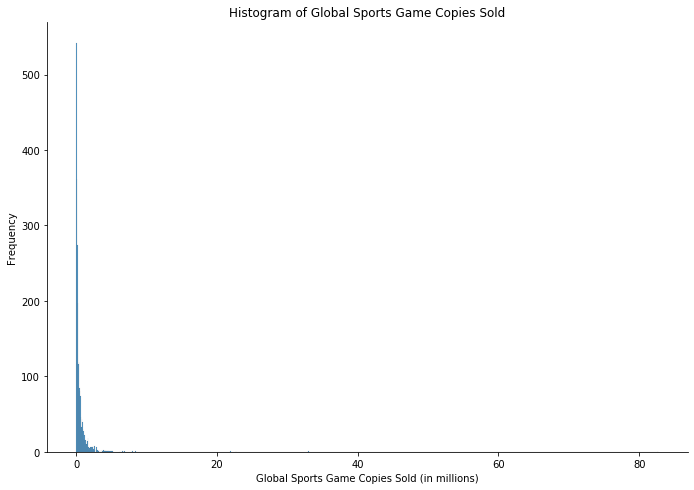

In [10]:
# Sports Histogram
ax = sns.displot(sports, height=6.5, aspect=1.5)
ax.set(xlabel='Global Sports Game Copies Sold (in millions)', ylabel='Frequency')
plt.gca().set_title('Histogram of Global Sports Game Copies Sold')
plt.show()

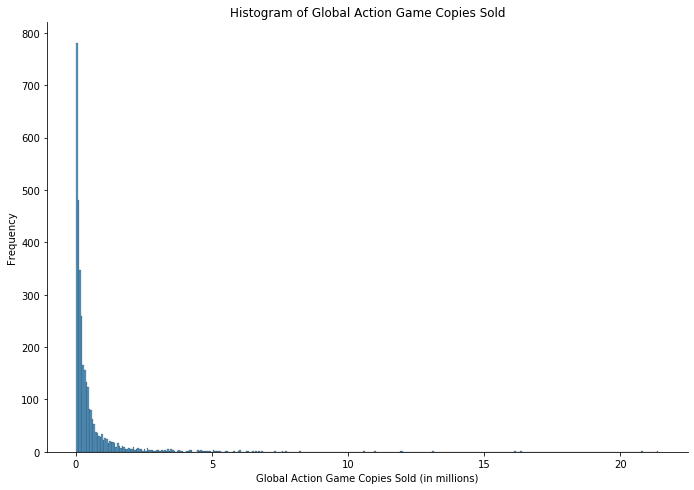

In [11]:
# Action Histogram
ax = sns.displot(action, height=6.5, aspect=1.5)
ax.set(xlabel='Global Action Game Copies Sold (in millions)', ylabel='Frequency')
plt.gca().set_title('Histogram of Global Action Game Copies Sold')
plt.show()

### Density Plots (KDE)
Source for KDE code: [Seaborn documentation](https://seaborn.pydata.org/tutorial/distributions.html#tutorial-kde)

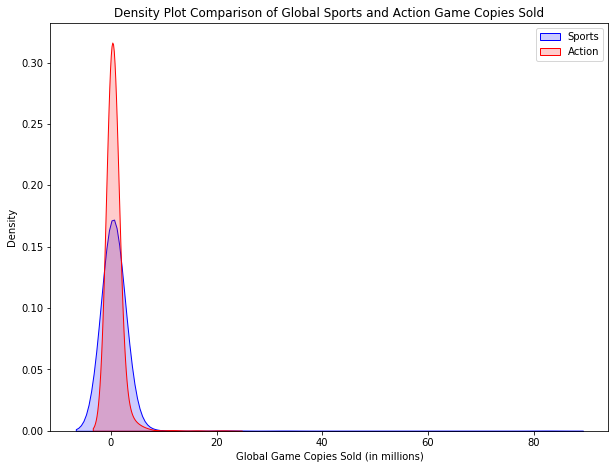

In [12]:
# shaded kernel density estimate (KDE) plots
plt.figure(figsize=(10, 7.5))
ax = sns.kdeplot(sports, alpha=0.2, color='blue', shade=True, label='Sports', bw_adjust=5)
sns.kdeplot(action, alpha=0.2, ax=ax, color='red', shade=True, label='Action', bw_adjust=5)
ax.set(xlabel='Global Game Copies Sold (in millions)', ylabel='Density')
ax.legend()
plt.gca().set_title('Density Plot Comparison of Global Sports and Action Game Copies Sold')
plt.show()

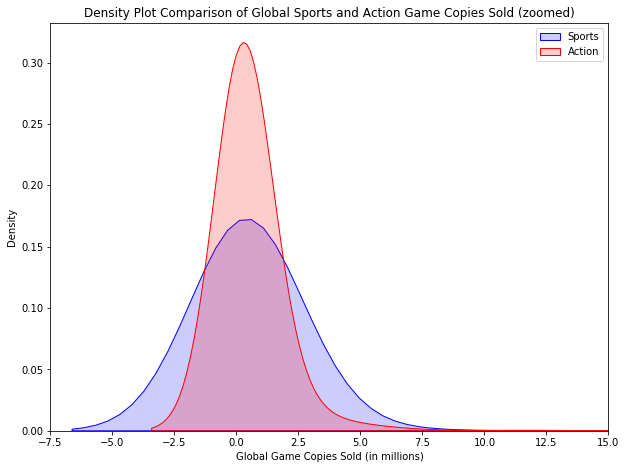

In [13]:
# zooming in on highest density of the shaded density plots
plt.figure(figsize=(10, 7.5))
ax = sns.kdeplot(sports, alpha=0.2, color='blue', shade=True, label='Sports', bw_adjust=5)
sns.kdeplot(action, alpha=0.2, ax=ax, color='red', shade=True, label='Action', bw_adjust=5)
ax.set(xlabel='Global Game Copies Sold (in millions)', ylabel='Density')
ax.legend()
plt.xlim(-7.5,15)
plt.gca().set_title('Density Plot Comparison of Global Sports and Action Game Copies Sold (zoomed)')
plt.show()

### Box Plot (with outliers omitted)

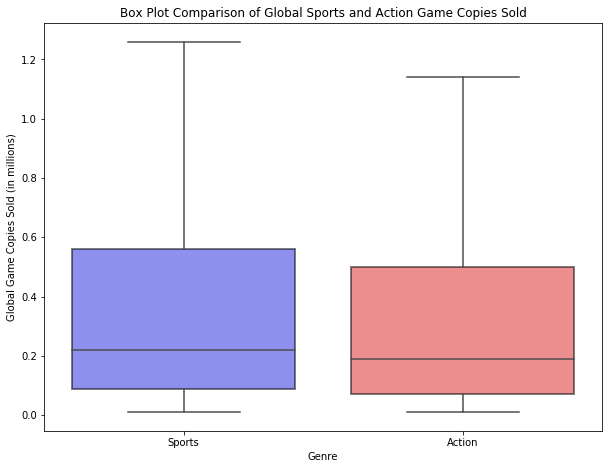

In [14]:
# box plot to compare both populations
plt.figure(figsize=(10, 7.5))
color_pallete = {'Sports': 'blue', 'Action': 'red'}
ax = sns.boxplot(x='Genre', y='Global_Sales', data=df_genres, showfliers=False, palette=color_pallete)
ax.set(xlabel='Genre', ylabel='Global Game Copies Sold (in millions)')
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor='black')
plt.gca().set_title('Box Plot Comparison of Global Sports and Action Game Copies Sold')
plt.show()

## Data Descriptions

### Sports Video Game Sales SOCS:
**Shape:** The sports video game sales data is skewed to the right, as evidenced by the box plot and histogram. Thus, the mean will be greater than the median. This also suggests that most video games did not generate large numbers of unit sales.

**Outliers:** There are $ 226 $ total outliers in the sports genre data. All of them were upper outliers (higher than the rest of the distribution of the data).

**Center:** The sports genre mean sales are $ 0.567319 $ million units. The sports genre median sales are $ 0.22 $ million units.

**Spread:** The IQR of the data is $ 0.47 $ million copies, which means the difference between quartile 3 and quartile 1 is $ 0.47 $ million. The range is $ 82.73 $ million copies, which means the difference between the highest and lowest values is $ 82.73 $ million. The standard deviation is $ 2.089716 $ million copies, which means each data value, on average, lies $ 2.090 $ million video game copies from the mean.

### Action Video Game Sales SOCS:
**Shape:** The action video game sales data is skewed to the right, as evidenced by the box plot and histogram. The mean will be greater than the median, and most video games did not generate large numbers of unit sales.

**Outliers:** There are $ 358 $ total outliers in the action genre data. All of them were upper outliers (higher than the rest of the data distribution).

**Center:** The action genre mean sales are $ 0.528100 $ million units. The action genre median sales are $ 0.19 $ million units.

**Spread:** The IQR of the data is $ 0.43 $ million copies, which means the difference between quartile 3 and quartile 1 is $ 0.43 $ million. The range is $ 21.39 $ million copies, which means the difference between the highest and lowest values is $ 21.39 $ million. The standard deviation is $ 1.156427 $ million copies, which means each data value, on average, lies $ 1.156 $ million video game copies from the mean.


# Inferences

### Conditions That Must Be Met
*This applies for both confidence intervals and significance tests.*
###### 1. Random Sample (data must be randomly sampled from population)
###### 2. Independent Sample ($ n\ \le 0.10p $)
###### 3. Normality (population has normal distribution, or $ n\ \ge\ 30 $, or $ n\ \ge\ 15 $ because t-procedures are robust)

#### 1. Random Sample
By looking at the dataset, particularly the rank column and the global sales column, it is fair to assume that the author sorted by sales (top selling first) when scraping. This would imply that the sample of video games in this dataset is not random and is rather a convenience sample. Thus, this is a shortcoming of the sampling methodology, and the result will be that the confidence interval and significance test cannot be accurately generalized to the population of interest (which includes ALL video games in the action and sports genres).

#### 2. Independent Sample
Remember, there are $ 2346 $ sports games in the dataset and $ 3316 $ action games.

The population for each sample has to be at least 10 times greater than the sample size to satisfy the independence condition. 
&nbsp;

&nbsp;

For sports games, the population must have at least $ 10n_{s} = 10(2346) = 23460 $ sports games with sales as of 2016. It is safe to assume that there are more than this number of video games on the market because anyone can create and sell a video game and the population can contain games with past sales (not just for 2016).
&nbsp;

&nbsp;

For action games, the population must have at least $ 10n_{a} = 10(3316) = 33160 $ sports games with sales as of 2016. It is safe to assume that there are more than this number of video games on the market because anyone can create and sell a video game and the population can contain games with past sales (not just for 2016).

#### 3. Normality
The samples include 2346 sports games and 3316 action games. This sample size from each population is over 30, so the normality condition is satisfied.

### The Question
The original question:


Which genre of video games had more global unit sales as of 2016: action or sports games?

### Confidence Interval For The Difference in The Sample Means (2-sample t-interval)

#### State:
We want to estimate the difference ($ \mu_{a} - \mu_{s} $) between the true mean of action game sales ($ \mu_{a} $) and the true mean of sports game sales ($ \mu_{s} $) at a 95% confidence level.

#### Plan (conditions were discussed earlier): 
To calculate the confidence interval for a difference in two sample means a 2-sample t-interval should be used:
$$ confidence\ interval\ =\ \ \left(\overline{x}_{a}\ -\ \overline{x}_{s}\right)\pm t^{*}\left(\sqrt{\frac{s_{a}^{2}}{n_{a}}+\frac{s_{s}^{2}}{n_{s}}}\right) $$

where $ \overline{x} $ is the mean of the sample,
$ t^{*} $ is the t-critical value for the 95% interval,
$ s $ is the standard deviation of the sample, and
$ n $ is the sample size.
The subscripts also denote which population the sample is from.

In [15]:
# Do:

from scipy.stats import t
# function to create a confidence interval
def confidence_interval(df1, df2, confidence_level):
    # 1st sample size
    n1 = len(df1)
    # 2nd sample size
    n2 = len(df2)
    # x1 - x2
    statistic = df1.mean() - df2.mean()
    # degrees of freedom - according to class notes should be the smaller of the sample sizes minus 1
    degrees_of_freedom = min(n1, n2) - 1
    # t*
    t_crit_val = t.ppf(confidence_level, degrees_of_freedom)
    # std of 1st sample
    std1 = df1.std()
    # std of 2nd sample
    std2 = df2.std()
    # margin of error
    margin_of_error = t_crit_val*(((std1**2/n1)+(std2**2/n2))**(1/2))
    # lower confidence interval bound
    lower_limit = statistic - margin_of_error
    # upper confidence interval bound
    upper_limit = statistic + margin_of_error
    # return interval in the form of a tuple
    return (lower_limit, upper_limit)

#rand_sample_1 = df_action.sample(n=331, random_state=1)
#rand_sample_2 = df_sports.sample(n=234, random_state=2)
confidence_interval(df_action, df_sports, .95)

(Global_Sales   -0.117527
 dtype: float64,
 Global_Sales    0.039089
 dtype: float64)

#### Interpretation + Conclusion for Confidence Interval
The confidence interval was $ (-0.117527, 0.039089) $, so we are 95% confident that the difference in population means of millions of video game unit sales for the two genres (action minus sports) is between -0.117527 million video game unit sales and 0.039089 million video game unit sales.
&nbsp;

&nbsp;

Because 0 is contained in the confidence interval, we can be 95% confident that there is no statistically significant difference between action game unit sales and sports game unit sales.

### Significance Test (2-sample t-test)

#### State:
Setting up a test:
$$ H_{0}:\ \mu_{a}-\mu_{s}=0 $$
$$ H_{a}:\ \mu_{a}-\mu_{s}\neq0 $$

Again, $ \mu_{a} $ will represent the true mean of the action game unit sales and $ \mu_{s} $ will represent the true mean of the sports game unit sales.

We can use an alpha value of 0.05 ($ \alpha = 0.05 $).
#### Plan (conditions discussed earlier):
A 2-sample t-test can be carried out using the following formula:
$$ t\ =\frac{\left(\overline{x}_{a}-\overline{x}_{s}\right)-\left(\mu_{a}-\mu_{s}\right)}{\sqrt{\frac{s_{a}^{2}}{n_{a}}+\frac{s_{s}^{2}}{n_{s}}}} $$
&nbsp;


A tCDF can then be used to determine the p-value. If the p-value is below the 0.05 significance level, then the null hypothesis will be rejected. 

In [16]:
# Do:
from scipy.stats import t

# function to find both the test statistic and p value
def significance_test(df1, df2, alpha):
    # size of 1st sample
    n1 = len(df1)
    # size of 2nd sample
    n2 = len(df2)
    # std of 1st sample
    std1 = df1.std()
    # std of 2nd sample
    std2 = df2.std()
    # the numerator of the standardized test statistic
    statistic_minus_parameter = (df1.mean() - df2.mean()) - (0)
    # standardized test statistic
    test_statistic = (statistic_minus_parameter)/(((std1**2/n1)+(std2**2/n2))**(1/2))
    # p-value from one-tailed test - source: https://stackoverflow.com/questions/23879049/finding-two-tailed-p-value-from-t-distribution-and-degrees-of-freedom-in-python
    one_sided_test = t.sf(abs(test_statistic), min(len(df1), len(df2)) - 1)
    # p-value from two-tailed test
    two_sided_test = 2 * one_sided_test
    # return the p-value from the two-tailed test
    return test_statistic, two_sided_test

significance_test(df_action, df_sports, 0.05)

(Global_Sales   -0.824111
 dtype: float64,
 array([0.40996016]))

#### Interpretation + Conclusion for Significance Test
The test statistic is -0.824111, and the p-value is 0.40996016. Because this p-value is greater than $ \alpha = 0.05 $, we fail to reject the null hypothesis, $ H_{0} $.
&nbsp;

&nbsp;

With the assumption that there is no difference between the population means of action and sports video game unit sales, the probability of observing a test statistic less than -0.824 or greater than 0.0824 is approximately 0.410. Therefore, there is not convincing enough evidence to conclude that there is a statistically significant difference between action game unit sales and sports game unit sales.

# Conclusions/Summary
There is no statistically significant difference between action and sports video game unit sales as of 2016. Both action games and sports games had approximately the same amount of unit sales as of 2016. These results were somewhat unexpected, as the sports genre sample appeared to have a greater mean and median than the action genre sample when they were initially compared.

## Further Questions to Study
It would be interesting to see whether there is a statistically significant difference between the net sales (in dollars) of sports and action video games. Another interesting area of study would be to explore whether unit sales of a video game can be predicted (perhaps with a neural network) based on other factors, such as genre, platform, and publisher.